<a href="https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_finetune_selfDrivingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and Setup environment

In [0]:
# This will automatically help adding GPU to the runtime
!nvidia-smi

Wed Apr 15 17:41:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Install required packages

In [0]:
## keras-retinanet to use compatible pretrained retinanet backbone
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
%cd -

## to use script for converting Udacity Self-driving dataset annotation into the COCO format.
!git clone https://github.com/jainxy/convert2COCO.git

# keras and tensorflow packages
!pip install --upgrade keras

# Install correct version of cocoapi
!git clone https://github.com/cocodataset/cocoapi
%cd cocoapi/PythonAPI
!python setup.py install
%cd -

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170863 sha256=010883442ac3386c35ca059ed4aed40668b49621e0f70875650e438fbcb6b4ca
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils
/content
fatal: destination path 'convert2COCO' already exists and is not an empty directory.
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
fatal: destination path 'cocoapi' already exists and is not an empty directory.
/content/cocoapi/PythonAPI
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cyth

#### Import packages

In [0]:
%tensorflow_version  1.x  # Ensure tensorflow 2.x package is imported 
import tensorflow as tf  # Tensorflow 2.x package.
# import tensorflow_hub as hub  # Tensorflow Hub package to get pretrained models.
from tensorboard import notebook # tensorboard to manage in-notebook Tensorboard instances
print(tf.version)
# %load_ext tensorboard # load the TensorBoard notebook extension

import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import cv2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from google.colab import drive

import os, time, sys, glob, pathlib
import urllib
import json
from pprint import pprint
from tqdm import tqdm, trange

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Ensure tensorflow 2.x package is imported`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
print("GPUs available - {}".format(tf.test.is_gpu_available()))

GPUs available - True


#### Functions

In [0]:
def check_create_path(path):
  '''
  Check if path exists else create
  '''
  if not os.path.exists(path):
    os.makedirs(path)
    print("Created Path - ", path)
  else:
    print("Path - ", path, " exists!")

def draw_bbox(img, bbox, color, thickness=20, label = None):
    """ Draws a bounding-box on an image with a given color.
    # Arguments
        img     : The image to draw on.
        bbox       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    bbox = np.array(bbox).astype(int)
    print(bbox)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness, cv2.LINE_AA)
    if label is not None:
        font = cv2.FONT_HERSHEY_PLAIN
        fontColor = (255, 255, 255)
        cv2.putText(img, label.upper(), (bbox[0], bbox[1] - 10), font, 8, fontColor, 15)

def disp_objects_img(img_row, data_path):
    img_name = img_row.Frame
    img_path = os.path.join(data_path, img_name)
    bbox = [img_row.xmin, img_row.ymin, img_row.xmax, img_row.ymax]
    label = img_row.Label
    img = cv2.imread(img_path)

    img_draw = img.copy()
    img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

    draw_bbox(img_draw, bbox, color=(255, 255, 0), label=label)

    plt.axis('off')
    plt.imshow(img_draw)
    plt.show()

def mount_gdrive():
  drive.mount('/content/gdrive')
  return "/content/gdrive/My Drive/"

# functions for inference
def predict(image, model, score_thresh=None):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  boxes /= scale

  if score_thresh is not None:
    labels = labels[:,scores[0]>score_thresh]
    boxes = boxes[:,scores[0]>score_thresh,:]
    scores = scores[:,scores[0]>score_thresh]
  return boxes, scores, labels

def draw_detections(image, boxes, scores, labels, score_thresh):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < score_thresh:
        break

    color = label_color(label+8)

    b = box.astype(int)
    draw_box(image, b, color=color, thickness=10)
    name = labels_to_names[label]
    print(name)
    caption = "{} {:.3f}".format(name, score)
    draw_caption(image, b, caption)

def show_detected_objects(image_row, data_dir, model, score_thresh):
  img_path = os.path.join(data_dir, image_row.Frame)
  
  image = cv2.imread(img_path)

  boxes, scores, labels = predict(image, model)

  img_draw = image.copy()
  img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.xmin, image_row.ymin, image_row.xmax, image_row.ymax
  ]
  draw_box(img_draw, true_box, color=(255, 255, 255), thickness=10)

  draw_detections(img_draw, boxes, scores, labels, score_thresh)

  plt.axis('off')
  plt.imshow(img_draw)
  plt.show()

def gen_pred_df(test_df, data_path, model, score_thresh):
  '''
  Generate Prediction dataframe for the testset
  '''
  # create empty dataframe
  col_list = list(test_df.columns)
  col_list.append('score')
  df_pred = pd.DataFrame(columns=col_list)
  # parse each image in the testset
  nTest = len(test_df.Frame.unique())
  start_time = time.perf_counter()
  for i, frame in enumerate(test_df.Frame.unique()):
    imgpath = os.path.join(data_path, frame)
    img = cv2.imread(imgpath)
    boxes, scores, labels = predict(img, model, score_thresh)
    # Fill dataset
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
      row_d = dict(Frame = frame,
                  xmin = int(box[0]),
                  ymin = int(box[1]),
                  xmax = int(box[2]),
                  ymax = int(box[3]),
                  Label = label,
                  score = round(score,3))
      df_pred = df_pred.append(row_d, ignore_index=True)
    if i%100 ==0:
      total_time = time.perf_counter() - start_time
      print("Inferenced on {}/{} image".format(i+1, nTest))
      if i>0: print("FPS: {}".format(int(100/total_time)))
      start_time = time.perf_counter()
  return df_pred

# convert different Datasets into nice COCO-styled JSON 
class COCOconvert():
    def __init__(self, img_dir, csv_anno_file, anno_coco_file, res=False):
        self.img_dir = img_dir
        self.csv_anno_file = csv_anno_file
        self.anno_coco_file = anno_coco_file
        self.res = res

    def gen_coco_cat_d(self, df_anno):
        coco_cat_l = []
        for cat_id, cat_name in enumerate(sorted(df_anno.Label.unique())):
            cat_dict = dict(id=cat_id+1, name=cat_name, supercategory='none')
            coco_cat_l.append(cat_dict)
        return coco_cat_l

    def get_cat_id(self, cat_name, coco_cat_l):
        cat_id = None
        for cat_d in coco_cat_l:
            if cat_d['name'] == cat_name:
                cat_id = cat_d['id']
                break
        return cat_id

    def gen_coco_images_d(self, df_anno, img_dir):
        coco_img_l = []
        for img_id, img_name in enumerate(df_anno.Frame.unique()):
            filepath = os.path.join(img_dir, img_name)
            if not os.path.exists(filepath):
                raise FileNotFoundError
            img_dict = dict(id=int(os.path.splitext(img_name)[0]), file_name=img_name, height=1200, width=1920)
            coco_img_l.append(img_dict)
        print("Number of images - {}".format(len(coco_img_l)))
        return coco_img_l

    def get_img_id(self, img_name, img_dir):
        filepath = os.path.join(img_dir, img_name)
        if not os.path.exists(filepath):
            raise FileNotFoundError
        img_id = int(os.path.splitext(img_name)[0])
        return img_id

    def gen_coco_anno_d(self, df_anno, img_dir, coco_cat_l):
        coco_anno_l = []
        for index, row in df_anno.iterrows():
            xmin = row.xmin
            ymin = row.ymin
            xmax = row.xmax
            ymax = row.ymax
            w = xmax - xmin
            h = ymax - ymin
            bbox = [xmin, ymin, w, h]
            img_name = row.Frame
            img_id = self.get_img_id(img_name, img_dir)
            cat_name = row.Label
            cat_id = self.get_cat_id(cat_name, coco_cat_l)

            anno_dict = dict(id=index+1, image_id=img_id, category_id=cat_id, 
                             bbox=bbox, iscrowd=0, area=w*h)
            if self.res:
              score = round(row.score, 3)
              anno_dict['score'] = score
            coco_anno_l.append(anno_dict)
        print("Number of Annotations - {}".format(len(coco_anno_l)))
        return coco_anno_l

    def create_coco_json(self):
        df_anno = pd.read_csv(self.csv_anno_file)
        # Generate list of categories
        COCO_CAT_L = self.gen_coco_cat_d(df_anno)
        pprint(COCO_CAT_L)

        # Generate list of images
        COCO_IMG_L = self.gen_coco_images_d(df_anno, self.img_dir)
        pprint(COCO_IMG_L[:5])

        # Generate list of annotations
        COCO_ANNO_L = self.gen_coco_anno_d(df_anno, self.img_dir, COCO_CAT_L)
        pprint(COCO_ANNO_L[:5])

        # Create final COCO-styled annotation dictionary
        COCO_ANNO_DICT = dict(
            categories = COCO_CAT_L,
            images = COCO_IMG_L,
            annotations = COCO_ANNO_L,
        #     type = "instances"
        )
        print(COCO_ANNO_DICT.keys())

        # dump to json file
        with open(self.anno_coco_file, 'w') as fp:
            if self.res:
                json.dump(COCO_ANNO_L, fp)
            else:
                json.dump(COCO_ANNO_DICT, fp)


#### Global/Constants/Flags

In [0]:
STORAGE_USE_GDRIVE = False  # Use google-drive for persistent storage and training checkpoints

_URL_IMG = "https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz"
_URL_LABEL = "https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv"

CLASS_NAMES = ["Car", "Truck", "Pedestrian"]
# AUTOTUNE = tf.data.experimental.AUTOTUNE

THRES_SCORE = 0.4

# Set random-seed for reproducibility
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

#### Select storage location - Local or Google-drive

In [0]:
if STORAGE_USE_GDRIVE:
  drive_path = mount_gdrive()
else:  # Use Colab VM storage
  drive_path = "/content/"
data_path = os.path.join(drive_path, 'dataset/')
check_create_path(data_path)

Path -  /content/dataset/  exists!


# Data
## Download -- Clean -- Prepare

#### Download and extract the dataset

In [0]:
img_tar_path = os.path.join(data_path, "object-detection-crowdai.tar.gz")
img_dir_path = os.path.join(data_path, "object-detection-crowdai/")
ann_csv_path = os.path.join(data_path, "labels_crowdai.csv")

# check and download the Image-datset tar file
if not os.path.exists(img_tar_path):
  print("Downloading tar file of image dataset ...")
  !wget -c -P "{data_path}" {_URL_IMG}
else:
  print("Tar file of image dataset exists at ", img_tar_path)
# extract tar-file
if not os.path.exists(img_dir_path):
  print("Extracting tar file of image dataset ...")
  !tar -xvf "{img_tar_path}" -C "{data_path}"
else:
  print("Extracted image dataset exists at ", img_dir_path)
img_dir_path = pathlib.Path(img_dir_path)

# check and download the Annotation CSV file
if not os.path.exists(ann_csv_path):
  print("Downloading Annotation CSV file ...")
  !wget -c -P "{data_path}" {_URL_LABEL}
else:
  print("Annotation CSV file exists at ", ann_csv_path)
!ls -l

Tar file of image dataset exists at  /content/dataset/object-detection-crowdai.tar.gz
Extracted image dataset exists at  /content/dataset/object-detection-crowdai/
Annotation CSV file exists at  /content/dataset/labels_crowdai.csv
total 36
drwxr-xr-x  8 root root 4096 Apr 15 17:32 cocoapi
drwxr-xr-x  3 root root 4096 Apr 15 16:28 convert2COCO
drwxr-xr-x  5 root root 4096 Apr 15 16:36 dataset
drwx------  4 root root 4096 Apr 15 15:21 gdrive
drwxr-xr-x 10 root root 4096 Apr 15 10:26 keras-retinanet
drwxr-xr-x  2 root root 4096 Apr 15 11:15 models
drwxr-xr-x  3 root root 4096 Apr 15 12:03 retinanet
drwxr-xr-x  1 root root 4096 Apr  3 16:24 sample_data
drwxr-xr-x  2 root root 4096 Apr 15 10:27 tblogs


In [0]:
img_l = img_dir_path.glob('*.jpg')
nImg = len(list(img_l))
print("Number of images - %d" % nImg)

Number of images - 9420


#### Create COCO version of the ground-truth annotation file

In [0]:
%cd "{data_path}"
IMG_DIR = "object-detection-crowdai"
csv_anno_file = "labels_crowdai.csv"
anno_coco_file = "labels_crowdai_coco.json"

# create coco-conversion object
coco_conv = COCOconvert(IMG_DIR, csv_anno_file, anno_coco_file)
# call conversion function
coco_conv.create_coco_json()
anno_coco_path = os.path.abspath(anno_coco_file)

# backup to google drive
!cp "{anno_coco_path}" "{gdpath}"
%cd "{drive_path}"

/content/dataset
[{'id': 1, 'name': 'Car', 'supercategory': 'none'},
 {'id': 2, 'name': 'Pedestrian', 'supercategory': 'none'},
 {'id': 3, 'name': 'Truck', 'supercategory': 'none'}]
Number of images - 9218
[{'file_name': '1479498371963069978.jpg',
  'height': 1200,
  'id': 1479498371963069978,
  'width': 1920},
 {'file_name': '1479498372942264998.jpg',
  'height': 1200,
  'id': 1479498372942264998,
  'width': 1920},
 {'file_name': '1479498373962951201.jpg',
  'height': 1200,
  'id': 1479498373962951201,
  'width': 1920},
 {'file_name': '1479498374962942172.jpg',
  'height': 1200,
  'id': 1479498374962942172,
  'width': 1920},
 {'file_name': '1479498375942206592.jpg',
  'height': 1200,
  'id': 1479498375942206592,
  'width': 1920}]
Number of Annotations - 72064
[{'area': 13320,
  'bbox': [785, 533, 120, 111],
  'category_id': 1,
  'id': 1,
  'image_id': 1479498371963069978,
  'iscrowd': 0},
 {'area': 26058,
  'bbox': [89, 551, 202, 129],
  'category_id': 1,
  'id': 2,
  'image_id': 1479

#### Prepare dataset for training

In [0]:
%cd {data_path}
!ls
IMG_DIR = "object-detection-crowdai"
anno_coco_file = "labels_crowdai_coco.json"
# Read existing csv as dataframe
df_anno = pd.read_csv("labels_crowdai.csv")
# Filter dataset for incorrect labelling
df_anno = df_anno[(df_anno['xmax']>df_anno['xmin']) & (df_anno['ymax']>df_anno['ymin'])]
print(df_anno.shape)
# transform data as per the requiremnts of training script
col_names = ['Frame', 'xmin', 'ymin', 'xmax', 'ymax', 'Label']
df_anno = df_anno.reindex(columns=col_names)
df_anno['Frame'] = df_anno['Frame'].apply(lambda x: os.path.join(IMG_DIR, x))

df_anno.head()

/content/dataset
annotations_test.csv	  object-detection-crowdai.tar.gz
annotations_train.csv	  pred_df.csv
classes.csv		  pred_name_coco.json
labels_crowdai_coco.json  pred_name_df.csv
labels_crowdai.csv	  __pycache__
object-detection-crowdai  udacity_self_driving_to_coco.py
(72060, 7)


,Frame,xmin,ymin,xmax,ymax,Label
0,object-detection-crowdai/1479498371963069978.jpg,785,533,905,644,Car
1,object-detection-crowdai/1479498371963069978.jpg,89,551,291,680,Car
2,object-detection-crowdai/1479498371963069978.jpg,268,546,383,650,Car
3,object-detection-crowdai/1479498371963069978.jpg,455,522,548,615,Truck
4,object-detection-crowdai/1479498371963069978.jpg,548,522,625,605,Truck


#### Split dataset into training-testing folds

In [0]:
train_df, test_df = train_test_split(
  df_anno, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

#### Display some samples

[  0 544 299 789]


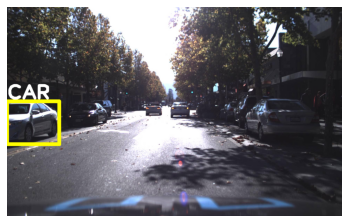

[893 533 923 563]


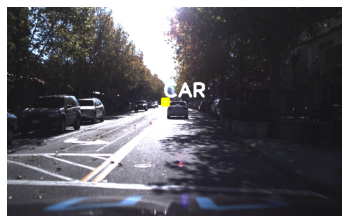

In [0]:
disp_objects_img(test_df.iloc[31], data_path)
disp_objects_img(train_df.iloc[18], data_path)

#### Save annotations as csv files for the training script

In [0]:
ANNOTATIONS_TRAIN_FILE = 'annotations_train.csv'
ANNOTATIONS_TEST_FILE = 'annotations_test.csv'
CLASSES_FILE = 'classes.csv'
train_df.to_csv(ANNOTATIONS_TRAIN_FILE, index=False, header=None)
test_df.to_csv(ANNOTATIONS_TEST_FILE, index=False, header=None)

classes = sorted(df_anno.Label.unique())
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

ANNOTATIONS_TRAIN_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TRAIN_FILE)
ANNOTATIONS_TEST_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TEST_FILE)
CLASSES_FILEPATH = os.path.join(os.getcwd(), CLASSES_FILE)

## List files and head-content of the csv files
!ls
%cd /content/
!head "{ANNOTATIONS_TRAIN_FILEPATH}" -n 3
!head "{ANNOTATIONS_TEST_FILEPATH}" -n 3
!head "{CLASSES_FILEPATH}"

annotations_test.csv   classes.csv	   object-detection-crowdai
annotations_train.csv  labels_crowdai.csv  object-detection-crowdai.tar.gz
/content
object-detection-crowdai/1479503944322290167.jpg,650,568,695,607,Car
object-detection-crowdai/1479504559883215179.jpg,605,564,681,630,Car
object-detection-crowdai/1479502077716170613.jpg,508,580,610,652,Car
object-detection-crowdai/1479505939475902144.jpg,328,590,364,626,Car
object-detection-crowdai/1479498377463264578.jpg,1560,593,1637,653,Car
object-detection-crowdai/1479504698892976645.jpg,361,290,1238,1049,Car
Car,0
Pedestrian,1
Truck,2


# Training

#### Download pretrained retinanet backbone

In [0]:
snapshot_path = os.path.join(drive_path, 'models/')
os.makedirs(snapshot_path, exist_ok=True)
PRETRAINED_MODEL = os.path.join(snapshot_path, 'pretrained_model.h5')

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
if not os.path.exists(PRETRAINED_MODEL):
  urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
  print('Downloaded pretrained model to ' + PRETRAINED_MODEL)
else:
  print('Pretrained model present at ' + PRETRAINED_MODEL)

# Tensorboard logs directory
tblogs_path = os.path.join(drive_path, 'tblogs/')
os.makedirs(tblogs_path, exist_ok=True)

Downloaded pretrained model to /content/models/pretrained_model.h5


#### Perform training

In [0]:
%cd keras-retinanet/

!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights "{PRETRAINED_MODEL}" \
--batch-size 8 --steps 1000 --epochs 1 --snapshot-path "{snapshot_path}" --weighted-average \
--tensorboard-dir "{tblogs_path}" csv "{ANNOTATIONS_TRAIN_FILEPATH}" "{CLASSES_FILEPATH}" 

/content/keras-retinanet
Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (720,)).
  weight_values[i].shape))
2020-04-15 10:27:19.327287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-15 10:27:19.329821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-15 10:27

#### Mount google-drive to backup the artifacts

In [0]:
gdpath = mount_gdrive()
print(gdpath)
!cp -r "{tblogs_path}" "{gdpath}"
!cp -r "{snapshot_path}" "{gdpath}"
%cd "{drive_path}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/


# Inference and Visualization

#### Load trained model and convert for inference

In [0]:
!ls "{snapshot_path}"

pretrained_model.h5  resnet50_csv_01.h5


In [0]:
model_path = os.path.join(snapshot_path, sorted(os.listdir(snapshot_path), reverse=True)[0])
print(model_path)

# Load model from file and convert for inference
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILEPATH, header=None).T.loc[0].to_dict()
print(labels_to_names)

/content/models/resnet50_csv_01.h5
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors


#### Visualize Inference on few samples

Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car


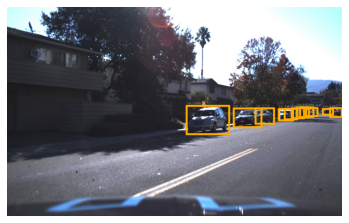

In [0]:
show_detected_objects(test_df.iloc[1], data_path, model, THRES_SCORE)

Car
Car
Car
Car
Car
Pedestrian
Car
Car


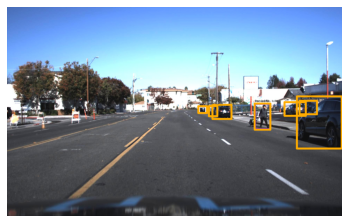

In [0]:
show_detected_objects(test_df.iloc[4], data_path, model, THRES_SCORE)

#### Perform Inference on the testset

In [0]:
pred_df = gen_pred_df(test_df, data_path, model, THRES_SCORE)

Inferenced on 1/6951 image
Inferenced on 101/6951 image
FPS: 5
Inferenced on 201/6951 image
FPS: 5
Inferenced on 301/6951 image
FPS: 5
Inferenced on 401/6951 image
FPS: 5
Inferenced on 501/6951 image
FPS: 5
Inferenced on 601/6951 image
FPS: 5
Inferenced on 701/6951 image
FPS: 5
Inferenced on 801/6951 image
FPS: 5
Inferenced on 901/6951 image
FPS: 5
Inferenced on 1001/6951 image
FPS: 5
Inferenced on 1101/6951 image
FPS: 5
Inferenced on 1201/6951 image
FPS: 5
Inferenced on 1301/6951 image
FPS: 5
Inferenced on 1401/6951 image
FPS: 5
Inferenced on 1501/6951 image
FPS: 5
Inferenced on 1601/6951 image
FPS: 5
Inferenced on 1701/6951 image
FPS: 5
Inferenced on 1801/6951 image
FPS: 5
Inferenced on 1901/6951 image
FPS: 5
Inferenced on 2001/6951 image
FPS: 5
Inferenced on 2101/6951 image
FPS: 5
Inferenced on 2201/6951 image
FPS: 5
Inferenced on 2301/6951 image
FPS: 5
Inferenced on 2401/6951 image
FPS: 5
Inferenced on 2501/6951 image
FPS: 5
Inferenced on 2601/6951 image
FPS: 5
Inferenced on 2701/6

#### Save as CSV files

In [0]:
pred_name_df = pred_df.copy()
pred_name_df['Label'] = pred_name_df['Label'].apply(lambda x: labels_to_names[x])
pred_name_df['Frame'] = pred_name_df['Frame'].apply(lambda x: os.path.basename(x))
pred_name_df.head(3)

,Frame,xmin,ymin,xmax,ymax,Label,score
0,1479505939475902144.jpg,781,578,866,641,Car,0.698
1,1479505939475902144.jpg,522,426,694,661,Car,0.624
2,1479505939475902144.jpg,1080,507,1417,743,Car,0.623


In [0]:
pred_csv_path = os.path.join(data_path, 'pred_df.csv')
pred_df.to_csv(pred_csv_path, index=False)
pred_name_csv_path = os.path.join(data_path, 'pred_name_df.csv')
pred_name_df.to_csv(pred_name_csv_path, index=False)
# backup to gdrive
!cp "{pred_csv_path}" "{gdpath}"
!cp "{pred_name_csv_path}" "{gdpath}"

#### Convert prediction CSV to COCO format json

In [0]:
COCOconvert=2

In [0]:
%cd "{data_path}"
IMG_DIR = "object-detection-crowdai"
csv_anno_file = "pred_name_df.csv"
anno_coco_file = "pred_name_coco.json"

# create coco-conversion object
coco_conv = COCOconvert(IMG_DIR, csv_anno_file, anno_coco_file, res=True)
# call conversion function
coco_conv.create_coco_json()
anno_coco_path = os.path.abspath(anno_coco_file)

# backup to google drive
!cp "{anno_coco_path}" "{gdpath}"
%cd "{drive_path}"

/content/dataset
[{'id': 1, 'name': 'Car', 'supercategory': 'none'},
 {'id': 2, 'name': 'Pedestrian', 'supercategory': 'none'},
 {'id': 3, 'name': 'Truck', 'supercategory': 'none'}]
Number of images - 6899
[{'file_name': '1479505939475902144.jpg',
  'height': 1200,
  'id': 1479505939475902144,
  'width': 1920},
 {'file_name': '1479498377463264578.jpg',
  'height': 1200,
  'id': 1479498377463264578,
  'width': 1920},
 {'file_name': '1479504698892976645.jpg',
  'height': 1200,
  'id': 1479504698892976645,
  'width': 1920},
 {'file_name': '1479504573885274961.jpg',
  'height': 1200,
  'id': 1479504573885274961,
  'width': 1920},
 {'file_name': '1479503269298689748.jpg',
  'height': 1200,
  'id': 1479503269298689748,
  'width': 1920}]
Number of Annotations - 47736
[{'area': 5355,
  'bbox': [781, 578, 85, 63],
  'category_id': 1,
  'id': 1,
  'image_id': 1479505939475902144,
  'iscrowd': 0,
  'score': 0.698},
 {'area': 40420,
  'bbox': [522, 426, 172, 235],
  'category_id': 1,
  'id': 2,
  

#### Computer COCO mAP metrics

In [0]:
# Reference: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
annType = 'bbox'
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'

# initialize COCO ground truth api
annFile = os.path.join(data_path, 'labels_crowdai_coco.json')
cocoGt=COCO(annFile)

# initialize COCO detections api
resFile = os.path.join(data_path, 'pred_name_coco.json')
cocoDt=cocoGt.loadRes(resFile)

imgIds=sorted(cocoGt.getImgIds())

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!


In [0]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.11s).
Accumulating evaluation results...
DONE (t=1.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=10

# Deploy

### Prepare and save model for TF-serving

#### Define a destination path for the model

In [0]:
print(model)
MODEL_EXPORT_DIR = os.path.join(drive_path, 'retinanet')
MODEL_VERSION = 1
MODEL_EXPORT_PATH = os.path.join(MODEL_EXPORT_DIR, str(MODEL_VERSION))
print("Model dir: ", MODEL_EXPORT_PATH)

Model dir:  /content/retinanet/1


#### Save the model to the MODEL_EXPORT_PATH

In [0]:
# Print the input tensors of the model
print(model.inputs)
# Create an input mapping, and name each of the input tensors.
input_names = ['image']
name_to_input = {name: t_input for name, t_input in zip(input_names, model.inputs)}
print(name_to_input)

[<tf.Tensor 'input_1_1:0' shape=(?, ?, ?, 3) dtype=float32>]
{'image': <tf.Tensor 'input_1_1:0' shape=(?, ?, ?, 3) dtype=float32>}


In [0]:
tf.saved_model.simple_save(
    keras.backend.get_session(),
    MODEL_EXPORT_PATH,
    inputs=name_to_input,
    outputs={t.name: t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/retinanet/1/saved_model.pb


In [0]:
# Show the saved resources
!ls -lh "{MODEL_EXPORT_PATH}"
!ls -lh "{MODEL_EXPORT_PATH}/variables"

total 3.3M
-rw-r--r-- 1 root root 3.3M Apr 15 12:03 saved_model.pb
drwxr-xr-x 2 root root 4.0K Apr 15 12:03 variables
total 475M
-rw-r--r-- 1 root root 475M Apr 15 12:03 variables.data-00000-of-00001
-rw-r--r-- 1 root root  31K Apr 15 12:03 variables.index


#### Mount google-drive to backup the servable model

In [0]:
gdpath = mount_gdrive()
print(gdpath)
!cp -r "{MODEL_EXPORT_DIR}" "{gdpath}"
%cd "{drive_path}"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/
/content


# Tensorboard
Upload TB logs to tensorboard.dev for hosting publically 

In [0]:
!tensorboard dev upload --logdir "keras-retinanet/tblogs" \
  --name "Training Retinanet on Udacity Self-driving Car dataset" \
  --description "Training results from https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_finetune_selfDrivingDataset.ipynb"

!tensorboard dev list